In [1]:
import networkx as nx
from scipy.sparse import linalg as scp_sla
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.graph as graph
import sim_lib.graph_create as gc
import sim_lib.graph_networkx as gnx
import sim_lib.util as util
import sim_lib.attr_lib.util as attr_util
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 2

params = {
    'context_count' : 16,
    'k' : 8,
    'attr_func' : attr_util.discrete_pareto_val, # attribute assignment function
    'edge_util_func' : attr_util.total_inv_frequency,
    'edge_proposal' : attr_util.marginal_logistic,
    'vtx_util' : attr_util.logistic,
    'edge_selection' : attr_util.iter_drop_max_objective,
    'attr_copy' : attr_util.indep_attr_copy,
    'seed_type' : 'clique', # Type of seed network
    'vtx_types' :
        {
            'wide' : { 'direct_cost' : 10,
                      'indirect_cost' : 30,
                      'likelihood' : 0.5,
                      'color' : 'blue' },
            'tall' : { 'direct_cost' : 30,
                      'indirect_cost' : 10,
                      'likelihood' : 0.5,
                      'color' : 'red' }
        }
}

assert sum([ t['likelihood'] for t in params['vtx_types'].values()]) == 1.0

In [3]:
def graph_density(G):
    denum = (G.num_people * (G.num_people - 1))
    num = sum([ v.degree for v in G.vertices])
    return num / denum

def second_eigv(G):
    G_nx = gnx.graph_to_nx(G)
    laplacian = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_nx)
    eigvals = scp_sla.eigs(laplacian, return_eigenvectors=False)
    eigvals.sort()
    return eigvals[1]

def apl(G):
    G_nx = gnx.graph_to_nx(G)
    return nx.average_shortest_path_length(G_nx)

def diam(G):
    G_nx = gnx.graph_to_nx(G)
    return nx.diameter(G_nx)

def social_edge_welfare(G):
    return sum([ v.total_edge_util for v in G.vertices ]) / 2

def modularity(G):
    partitions = nx_comm.greedy_modularity_communities(G_nx)
    return nx_comm.modularity(G_nx, partitions)

In [4]:
def plot_distributions(G):
    
    # Degree distribution
    degree_dist = [ v.degree for v in G.vertices ]
    norm_degree_dist = []
    if max(degree_dist) == 0:
        norm_degree_dist = [ 0 for d in degree_dist ]
    else:
        norm_degree_dist = [ d / max(degree_dist) for d in degree_dist ]
    
    G_nx = gnx.graph_to_nx(G)
    eigv_centralities = nx.eigenvector_centrality(G_nx, weight='util')
    eigv_centralities = list(eigv_centralities.values())
    
    metric_dists = [norm_degree_dist, eigv_centralities]
    dist_labels = ['norm degree', 'eigenvector cent']
    
    bins = np.linspace(0, 1, 100)
    plt.hist(metric_dists, bins, alpha=0.5, label=dist_labels)
    plt.legend(loc='upper right')
    plt.show()
    

In [5]:
def print_metrics(G):
    gd = graph_density(G)
    eig2 = second_eigv(G)
    sw = social_edge_welfare(G)
    try:
        avg_pl = apl(G)
    except:
        avg_pl = -1
    try:
        diameter = diam(G)
    except:
        diameter = -1
    
    print("""Graph density: {0}, \n
    average path length: {1}, \n
    diameter: {2}, \n
    second eigenvalue: {3}, \n
    social edge welfare: {4} \n""".format(gd, avg_pl, diameter, eig2, sw))

0.35263720985113883
0.35263720985113883
0.36687184583812027


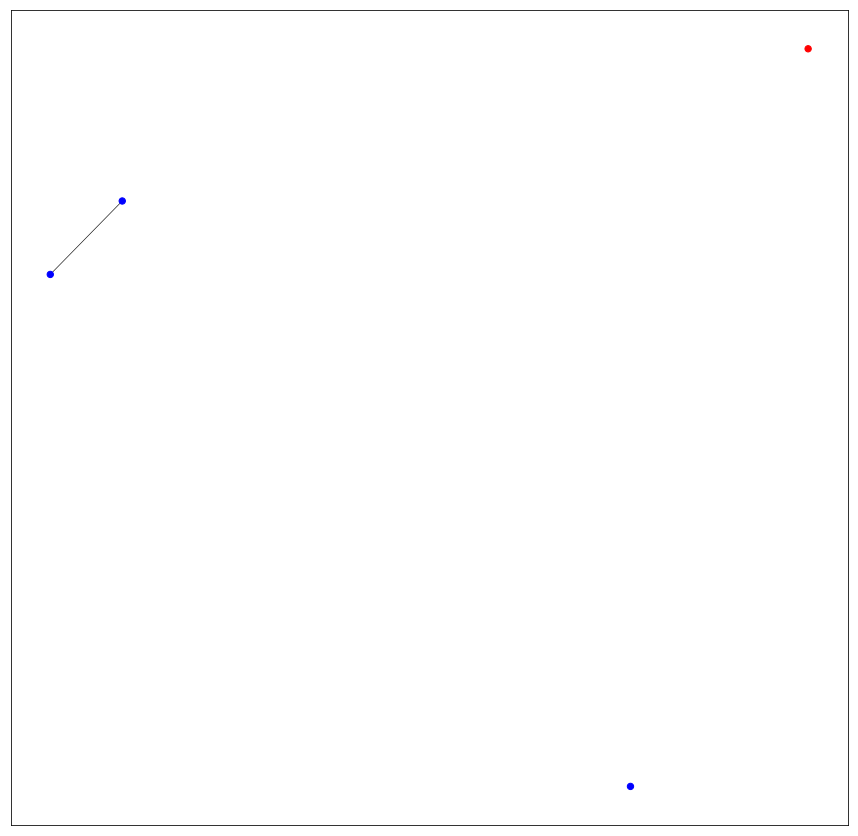

In [6]:
G = attribute_network(_N, params)

for it in range(2):
    add_attr_graph_vtx(G)
    calc_edges(G)
    simul_random_walk(G)
    
vis.draw_graph(G)